# Finding the error bar when interpolating the measurements

The RF losses in the T-resonator, due to the metal resistivities of the coaxial lines, is relatively unknown as the resisitivity that one can find in textbooks is in practice never achieved in real-life. 

In this notebook, the measured return loss of the propely matched T-resonator is compared to the RF model. The short-circuit lengths and resistivity and eventually the total RF losses in the model are adjusted to fit the measurement. This gives a estimation of the RF losses achieved in real-life.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import tresonator as T

%matplotlib notebook

Below we import the return loss measurements.

In [ ]:
# Load a matched configuration - S-parameter measurements
filename = 'data/RES2.ASC'

exp_freq,reS11,imS11 = np.loadtxt(filename, skiprows=14, delimiter=';', unpack=True)

exp_mag = np.sqrt(reS11**2 + imS11**2)
exp_mag_dB = 20*np.log10(exp_mag)

 The match frequency found in practice is:  

In [2]:
# find the match frequency 
exp_freq_match = exp_freq[np.argmin(exp_mag)]
print('Match frequency : {} MHz'.format(exp_freq_match/1e6))

Match frequency : 62.640625 MHz


Then we define an optimization function. The goal of this function is to minimize the error between the measured S11 and the simulated one, for the whole frequency band.

In [3]:
def optim_fun_impedance(short_properties, use_add_loss):
    L_DUT, Z_DUT, L_CEA, Z_CEA, add_loss = short_properties
    # calculates the resonator S11 vs freq
    S11dB = []
    for f in exp_freq:
        if not use_add_loss: # force no additional loss is requested
            add_loss = 1
        _cfg = T.Configuration(f, P_in=1, L_DUT=L_DUT, L_CEA=L_CEA, 
                               Z_short_DUT=Z_DUT, Z_short_CEA=Z_CEA, 
                               additional_losses=add_loss)
        S11dB.append(_cfg.S11dB())
    
    crit = np.sum( (np.array(S11dB) - exp_mag_dB)**2) #least square 
    print(short_properties, crit)
    return crit  

Below we launch the minimization process, starting from first guess.

Two minimization are launches: one taking into account a multiplicative loss coefficient, and one without.

In [4]:
# first guess
d_DUT_0 = 0.035 # m
d_CEA_0 = 0.035 # m
Z_DUT_0 = 0.01 # Ohm
Z_CEA_0 = 0.01 # Ohm
add_loss = 1.0 # multiplicative coefficient on total RF loss

In [5]:
# find a optimum taking into account additional losses
bounds_pties = ((20e-3, 63e-3), (1e-3, 1), # d,Z DUT
                (5e-3, 200e-3), (1e-3, 1), # d,Z CEA
                (0.1, 2)) # add losses
opt_res = minimize(optim_fun_impedance, (d_DUT_0, Z_DUT_0, d_CEA_0, Z_CEA_0, add_loss),
                  bounds=bounds_pties, args=(True))

[0.035 0.01  0.035 0.01  1.   ] 9956.686465532102
[0.03500001 0.01       0.035      0.01       1.        ] 9956.702965904995
[0.035      0.01000001 0.035      0.01       1.        ] 9956.684455598182
[0.035      0.01       0.03500001 0.01       1.        ] 9956.687130777014
[0.035      0.01       0.035      0.01000001 1.        ] 9956.68555547423
[0.035      0.01       0.035      0.01       1.00000001] 9956.686416454628
[0.02  1.    0.005 1.    2.   ] 6430.982456966881
[0.02000001 1.         0.005      1.         2.        ] 6430.982422324432
[0.02       0.99999999 0.005      1.         2.        ] 6430.982456548172
[0.02       1.         0.00500001 1.         2.        ] 6430.982443633074
[0.02       1.         0.005      0.99999999 2.        ] 6430.98245594576
[0.02       1.         0.005      1.         1.99999999] 6430.982456923171
[0.02024813 1.         0.00512956 1.         2.        ] 6429.953005427562
[0.02024814 1.         0.00512956 1.         2.        ] 6429.952971247703
[0

[0.03931446 0.09282881 0.08048006 0.09473161 0.82755104] 7106.887615079389
[0.03931446 0.09282881 0.08048005 0.09473162 0.82755104] 7106.887614973939
[0.03931446 0.09282881 0.08048005 0.09473161 0.82755105] 7106.8876231841
[0.03182913 0.12184942 0.04270823 0.12435356 1.05747863] 5934.231732122874
[0.03182914 0.12184942 0.04270823 0.12435356 1.05747863] 5934.233073412409
[0.03182913 0.12184943 0.04270823 0.12435356 1.05747863] 5934.231762135775
[0.03182913 0.12184942 0.04270824 0.12435356 1.05747863] 5934.232777146182
[0.03182913 0.12184942 0.04270823 0.12435357 1.05747863] 5934.231730531351
[0.03182913 0.12184942 0.04270823 0.12435356 1.05747864] 5934.231732228429
[0.03075468 0.12601507 0.03728641 0.12860553 1.09048274] 5515.9470590022065
[0.03075469 0.12601507 0.03728641 0.12860553 1.09048274] 5515.945697752119
[0.03075468 0.12601508 0.03728641 0.12860553 1.09048274] 5515.94711088552
[0.03075468 0.12601507 0.03728642 0.12860553 1.09048274] 5515.947323255922
[0.03075468 0.12601507 0.03

[0.03663391 0.001      0.02274007 0.00483506 0.94328946] 2118.447407728006
[0.03267464 0.001      0.0335701  0.00430905 0.95346048] 392.13240031012407
[0.03267465 0.001      0.0335701  0.00430905 0.95346048] 392.11785015390444
[0.03267464 0.00100001 0.0335701  0.00430905 0.95346048] 392.1308830368777
[0.03267464 0.001      0.03357011 0.00430905 0.95346048] 392.1254874182048
[0.03267464 0.001      0.0335701  0.00430906 0.95346048] 392.1317716872169
[0.03267464 0.001      0.0335701  0.00430905 0.95346049] 392.13236568950913
[0.063 1.    0.005 1.    2.   ] 8635.860155471053
[0.06299999 1.         0.005      1.         2.        ] 8635.858716545059
[0.063      0.99999999 0.005      1.         2.        ] 8635.860169176724
[0.063      1.         0.00500001 1.         2.        ] 8635.859609179057
[0.063      1.         0.005      0.99999999 2.        ] 8635.860159412849
[0.063      1.         0.005      1.         1.99999999] 8635.860155709954
[0.04221715 0.31535613 0.02457992 0.31762392 1.

[0.03302091 0.00313488 0.03262287 0.00647762 0.9550582 ] 173.80674042630395
[0.0330209  0.00313489 0.03262287 0.00647762 0.9550582 ] 173.76738999827523
[0.0330209  0.00313488 0.03262288 0.00647762 0.9550582 ] 173.78272304723956
[0.0330209  0.00313488 0.03262287 0.00647763 0.9550582 ] 173.7663892371221
[0.0330209  0.00313488 0.03262287 0.00647762 0.95505821] 173.76576335643892
[0.03307211 0.00318059 0.03247812 0.00653156 0.95449475] 162.89666821408076
[0.03307212 0.00318059 0.03247812 0.00653156 0.95449475] 162.90402742070626
[0.03307211 0.0031806  0.03247812 0.00653156 0.95449475] 162.89658864085186
[0.03307211 0.00318059 0.03247813 0.00653156 0.95449475] 162.899176971518
[0.03307211 0.00318059 0.03247812 0.00653157 0.95449475] 162.89662668686887
[0.03307211 0.00318059 0.03247812 0.00653156 0.95449476] 162.8966660453631
[0.03324491 0.00373401 0.03198244 0.00710821 0.95381066] 161.23110129908088
[0.03324492 0.00373401 0.03198244 0.00710821 0.95381066] 161.23422915942902
[0.03324491 0.00

[0.0330979  0.00342427 0.0323879  0.00677915 0.9542985 ] 159.82330163400528
[0.0330979  0.00342426 0.03238791 0.00677915 0.9542985 ] 159.82344880327352
[0.0330979  0.00342426 0.0323879  0.00677916 0.9542985 ] 159.8233020704456
[0.0330979  0.00342426 0.0323879  0.00677915 0.95429851] 159.82330297977035
[0.0330979  0.00342426 0.0323879  0.00677915 0.9542985 ] 159.82330302761704
[0.03309791 0.00342426 0.0323879  0.00677915 0.9542985 ] 159.82372328432962
[0.0330979  0.00342427 0.0323879  0.00677915 0.9542985 ] 159.8233016337176
[0.0330979  0.00342426 0.03238791 0.00677915 0.9542985 ] 159.82344880299942
[0.0330979  0.00342426 0.0323879  0.00677916 0.9542985 ] 159.82330207015332
[0.0330979  0.00342426 0.0323879  0.00677915 0.95429851] 159.82330297947067
[0.0330979  0.00342426 0.0323879  0.00677915 0.9542985 ] 159.82330302755526
[0.03309791 0.00342426 0.0323879  0.00677915 0.9542985 ] 159.82372328428846
[0.0330979  0.00342427 0.0323879  0.00677915 0.9542985 ] 159.82330163366035
[0.0330979  0.

[0.03309772 0.00344537 0.03238737 0.00680018 0.95432064] 159.81443993270557
[0.03309772 0.00344537 0.03238736 0.00680019 0.95432064] 159.81444134871012
[0.03309772 0.00344537 0.03238736 0.00680018 0.95432065] 159.81444134959773
[0.03309772 0.00344533 0.03238736 0.00680014 0.9543206 ] 159.81443979330066
[0.03309773 0.00344533 0.03238736 0.00680014 0.9543206 ] 159.81444613617015
[0.03309772 0.00344534 0.03238736 0.00680014 0.9543206 ] 159.8144395928997
[0.03309772 0.00344533 0.03238737 0.00680014 0.9543206 ] 159.81443859763988
[0.03309772 0.00344533 0.03238736 0.00680015 0.9543206 ] 159.8144397888766
[0.03309772 0.00344533 0.03238736 0.00680014 0.95432061] 159.81443979131586
[0.03309772 0.00344533 0.03238736 0.00680014 0.9543206 ] 159.81443969442324
[0.03309773 0.00344533 0.03238736 0.00680014 0.9543206 ] 159.8144460778222
[0.03309772 0.00344534 0.03238736 0.00680014 0.9543206 ] 159.81443949388586
[0.03309772 0.00344533 0.03238737 0.00680014 0.9543206 ] 159.81443851316448
[0.03309772 0.0

[0.03309772 0.00344539 0.03238737 0.00680017 0.95432061] 159.81444192534823
[0.03309772 0.00344539 0.03238737 0.00680016 0.95432062] 159.81444176752984
[0.03309772 0.00344535 0.03238737 0.00680015 0.9543206 ] 159.81443842537414
[0.03309773 0.00344535 0.03238737 0.00680015 0.9543206 ] 159.81446243426967
[0.03309772 0.00344536 0.03238737 0.00680015 0.9543206 ] 159.81443842423957
[0.03309772 0.00344535 0.03238738 0.00680015 0.9543206 ] 159.8144437432593
[0.03309772 0.00344535 0.03238737 0.00680016 0.9543206 ] 159.81443848733602
[0.03309772 0.00344535 0.03238737 0.00680015 0.95432061] 159.81443842726816
[0.03309772 0.00344534 0.03238736 0.00680014 0.9543206 ] 159.81443879869505
[0.03309773 0.00344534 0.03238736 0.00680014 0.9543206 ] 159.8144530202519
[0.03309772 0.00344535 0.03238736 0.00680014 0.9543206 ] 159.81443868680682
[0.03309772 0.00344534 0.03238737 0.00680014 0.9543206 ] 159.814440507622
[0.03309772 0.00344534 0.03238736 0.00680015 0.9543206 ] 159.81443882372284
[0.03309772 0.00

In [6]:
# find a optimum taking into account additional losses
bounds_pties = ((20e-3, 63e-3), (1e-3, 1), # d,Z DUT
                (5e-3, 200e-3), (1e-3, 1), # d,Z CEA
                (0.1, 2)) # add losses
opt_res_noloss = minimize(optim_fun_impedance, (d_DUT_0, Z_DUT_0, d_CEA_0, Z_CEA_0, add_loss),
                  bounds=bounds_pties, args=(False))


[0.035 0.01  0.035 0.01  1.   ] 9956.686465532102
[0.03500001 0.01       0.035      0.01       1.        ] 9956.702965904995
[0.035      0.01000001 0.035      0.01       1.        ] 9956.684455598182
[0.035      0.01       0.03500001 0.01       1.        ] 9956.687130777014
[0.035      0.01       0.035      0.01000001 1.        ] 9956.68555547423
[0.035      0.01       0.035      0.01       1.00000001] 9956.686465532102
[0.02  1.    0.005 1.    1.   ] 6426.6652751467045
[0.02000001 1.         0.005      1.         1.        ] 6426.6652351112725
[0.02       0.99999999 0.005      1.         1.        ] 6426.66527478101
[0.02       1.         0.00500001 1.         1.        ] 6426.665263314429
[0.02       1.         0.005      0.99999999 1.        ] 6426.665274144747
[0.02       1.         0.005      1.         1.00000001] 6426.6652751467045
[0.0203025  1.         0.00510005 1.         1.        ] 6425.3432104685435
[0.02030251 1.         0.00510005 1.         1.        ] 6425.34317115625

[0.03337407 0.0868357  0.03976826 0.08941607 1.        ] 5869.855629137477
[0.03337407 0.08683569 0.03976827 0.08941607 1.        ] 5869.857271782034
[0.03337407 0.08683569 0.03976826 0.08941608 1.        ] 5869.855604472702
[0.03337407 0.08683569 0.03976826 0.08941607 1.00000001] 5869.855627036539
[0.0314544  0.001      0.03988913 0.003922   1.        ] 5925.233769657443
[0.03145441 0.001      0.03988913 0.003922   1.        ] 5925.272168524175
[0.0314544  0.00100001 0.03988913 0.003922   1.        ] 5925.232175752777
[0.0314544  0.001      0.03988914 0.003922   1.        ] 5925.245239625403
[0.0314544  0.001      0.03988913 0.00392201 1.        ] 5925.233016597186
[3.14543961e-02 1.00000000e-03 3.98891306e-02 3.92199862e-03
 1.00000001e+00] 5925.233769657443
[0.03231089 0.03929718 0.0398352  0.04206676 1.        ] 5483.486945666899
[0.0323109  0.03929718 0.0398352  0.04206676 1.        ] 5483.4964000972095
[0.03231089 0.03929719 0.0398352  0.04206676 1.        ] 5483.486898828687
[0.

[0.04289566 0.001      0.00500001 0.00520886 1.        ] 3634.2207158500146
[0.04289566 0.001      0.005      0.00520887 1.        ] 3634.220379029681
[4.28956560e-02 1.00000000e-03 5.00000000e-03 5.20885506e-03
 1.00000001e+00] 3634.2207462951956
[0.03395126 0.001      0.03008589 0.00422458 1.        ] 871.5038561749407
[0.03395127 0.001      0.03008589 0.00422458 1.        ] 871.5204407788638
[0.03395126 0.00100001 0.03008589 0.00422458 1.        ] 871.5025695821882
[0.03395126 0.001      0.0300859  0.00422458 1.        ] 871.5081626767734
[0.03395126 0.001      0.03008589 0.00422459 1.        ] 871.5032907584214
[3.39512580e-02 1.00000000e-03 3.00858878e-02 4.22458014e-03
 1.00000001e+00] 871.5038561749407
[0.03244609 0.001      0.03430734 0.00405895 1.        ] 248.42025025302132
[0.0324461  0.001      0.03430734 0.00405895 1.        ] 248.50190337685538
[0.03244609 0.00100001 0.03430734 0.00405895 1.        ] 248.42034639471794
[0.03244609 0.001      0.03430735 0.00405895 1.      

[0.03313509 0.00278189 0.03228856 0.00594243 1.        ] 159.94249295848908
[0.03313509 0.00278189 0.03228855 0.00594244 1.        ] 159.94309828509265
[0.03313509 0.00278189 0.03228855 0.00594243 1.00000001] 159.943126747809
[0.03312786 0.00277452 0.03230827 0.00593427 1.        ] 159.87503237799632
[0.03312787 0.00277452 0.03230827 0.00593427 1.        ] 159.87396912077202
[0.03312786 0.00277453 0.03230827 0.00593427 1.        ] 159.87498302730864
[0.03312786 0.00277452 0.03230828 0.00593427 1.        ] 159.8745800318069
[0.03312786 0.00277452 0.03230827 0.00593428 1.        ] 159.87501269211998
[0.03312786 0.00277452 0.03230827 0.00593427 1.00000001] 159.87503237799632
[0.03310603 0.00274151 0.03236844 0.00589872 1.        ] 159.8293782884036
[0.03310604 0.00274151 0.03236844 0.00589872 1.        ] 159.82884782731242
[0.03310603 0.00274152 0.03236844 0.00589872 1.        ] 159.8293574776205
[0.03310603 0.00274151 0.03236845 0.00589872 1.        ] 159.82916017205235
[0.03310603 0.002

[0.03309903 0.00273729 0.03238754 0.00589375 1.        ] 159.82843308924487
[0.03309903 0.00273729 0.03238754 0.00589374 1.00000001] 159.8284363606249


Now the results:

In [29]:
print(f'With losses: \t\t d_DUT_0={opt_res.x[0]:.3}, Z_DUT_0={opt_res.x[1]:.3}',
        f' d_CEA_0={opt_res.x[2]:.3}, Z_CEA_0={opt_res.x[3]:.3}, add_loss={opt_res.x[4]:.3}')

print(f'Without losses: \t d_DUT_0={opt_res_noloss.x[0]:.3}, Z_DUT_0={opt_res_noloss.x[1]:.3},', 
      f'd_CEA_0={opt_res_noloss.x[2]:.3}, Z_CEA_0={opt_res_noloss.x[3]:.3}')


With losses: 		 d_DUT_0=0.0331, Z_DUT_0=0.00345  d_CEA_0=0.0324, Z_CEA_0=0.0068, add_loss=0.954
Without losses: 	 d_DUT_0=0.0331, Z_DUT_0=0.00274, d_CEA_0=0.0324, Z_CEA_0=0.00589


Graphically:

<IPython.core.display.Javascript object>


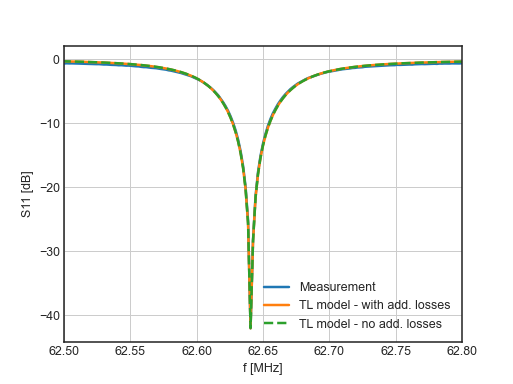

(62.5, 62.8)

In [32]:
P_in = 20e3 # W

S11dB = []
S11dB_noloss = []

L_DUT_opt, Z_DUT_opt, L_CEA_opt, Z_CEA_opt, add_loss_opt = opt_res.x
L_DUT_opt_nl, Z_DUT_opt_nl, L_CEA_opt_nl, Z_CEA_opt_nl, add_loss_opt_nl = opt_res_noloss.x

for f in exp_freq:
    _cfg = T.Configuration(f, P_in, L_DUT_opt, L_CEA_opt, 
                           Z_short_DUT = Z_DUT_opt, Z_short_CEA = Z_CEA_opt, 
                           additional_losses=add_loss_opt)
    S11dB.append(_cfg.S11dB())
    
    _cfg = T.Configuration(f, P_in, L_DUT_opt_nl, L_CEA_opt_nl, 
                           Z_short_DUT = Z_DUT_opt_nl, Z_short_CEA = Z_CEA_opt_nl, 
                           additional_losses=add_loss_opt_nl)
    S11dB_noloss.append(_cfg.S11dB())    
    

fig,ax=plt.subplots()
ax.plot(exp_freq/1e6, exp_mag_dB, lw=2)
ax.plot(exp_freq/1e6, S11dB, lw=2)
ax.plot(exp_freq/1e6, S11dB_noloss, lw=2, ls='--')
ax.legend(('Measurement', 'TL model - with add. losses', 'TL model - no add. losses'))
plt.grid(True)
ax.set_xlabel('f [MHz]')
ax.set_ylabel('S11 [dB]')
ax.set_xlim(62.5, 62.8)